In [1]:
import itertools
import multiprocessing as mp
import os

# os.environ["JAX_LOG_COMPILES"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

from functools import partial

import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from adaptive_spacing import adaptive_geomspace, smart_grid_smooth
from template_generation_jax import (
    chunked,
    generate_ellipsoid_diffraction,
    generate_parallelepiped_diffraction,
    generate_spaced_rotations,
    q_from_xyz,
    xyyz_from_detector_geometry,
)

# Experiment explanation

<figure>
  <img src="/gpfs/exfel/exp/SPB/202503/p008047/scratch/Konstantin/image_1.png" alt="Diffraction pattern" width="1600">
  <figcaption><b>Figure 1.</b> Experiment </figcaption>
</figure>


<figure>
  <img src="/gpfs/exfel/exp/SPB/202503/p008047/scratch/Konstantin/image.png" alt="Diffraction pattern" width="1600">
  <figcaption><b>Figure 2.</b> Detector </figcaption>
</figure>


## Forward model of the measurement


$ I_{det} =  \mathcal{P}\left\{ \mathcal{S\left\{ M \left\{ \mathrm{D_{ideal}} \right\} \right\}} \right\} $,
where $I_{det}$ is measured intensity in photons, $\mathcal{P}$ is a Poisson sampling, $\mathcal{S}$ is scaling by total amount of photons, $\mathcal{M}$ is masking operation and $\mathrm{D_{ideal}}$ is the ideal diffraction distribution calculated from shape parameters.

So in python it will be like:
```
I_masked =  I_simmulated * mask
I_scaled =  I_masked/I_masked.sum() * total_photons
I_det =  np.random.poisson(I_scaled)
```

## Key experimental parameters


- Detector to sample distance = 1.2 m
- Beam Diameter = 300 nm
- Particle Beam = 20 μm
- Pixel Size = 200 μm
- Photon Energy = 6000 ± 100 eV
- Wavelength = 0.20664e-9 m 

## Illustrations for the measuremental process

In [2]:
# Read some data and masks for illustration
with h5py.File('/gpfs/exfel/exp/SPB/202503/p008047/scratch/Konstantin/angular_correlations_run_76.h5','r') as f:
    masks = f['masks_centered'][:10,...]
    intensities = f['hits_sym'][:5000,...].sum(axis =(-1,-2))


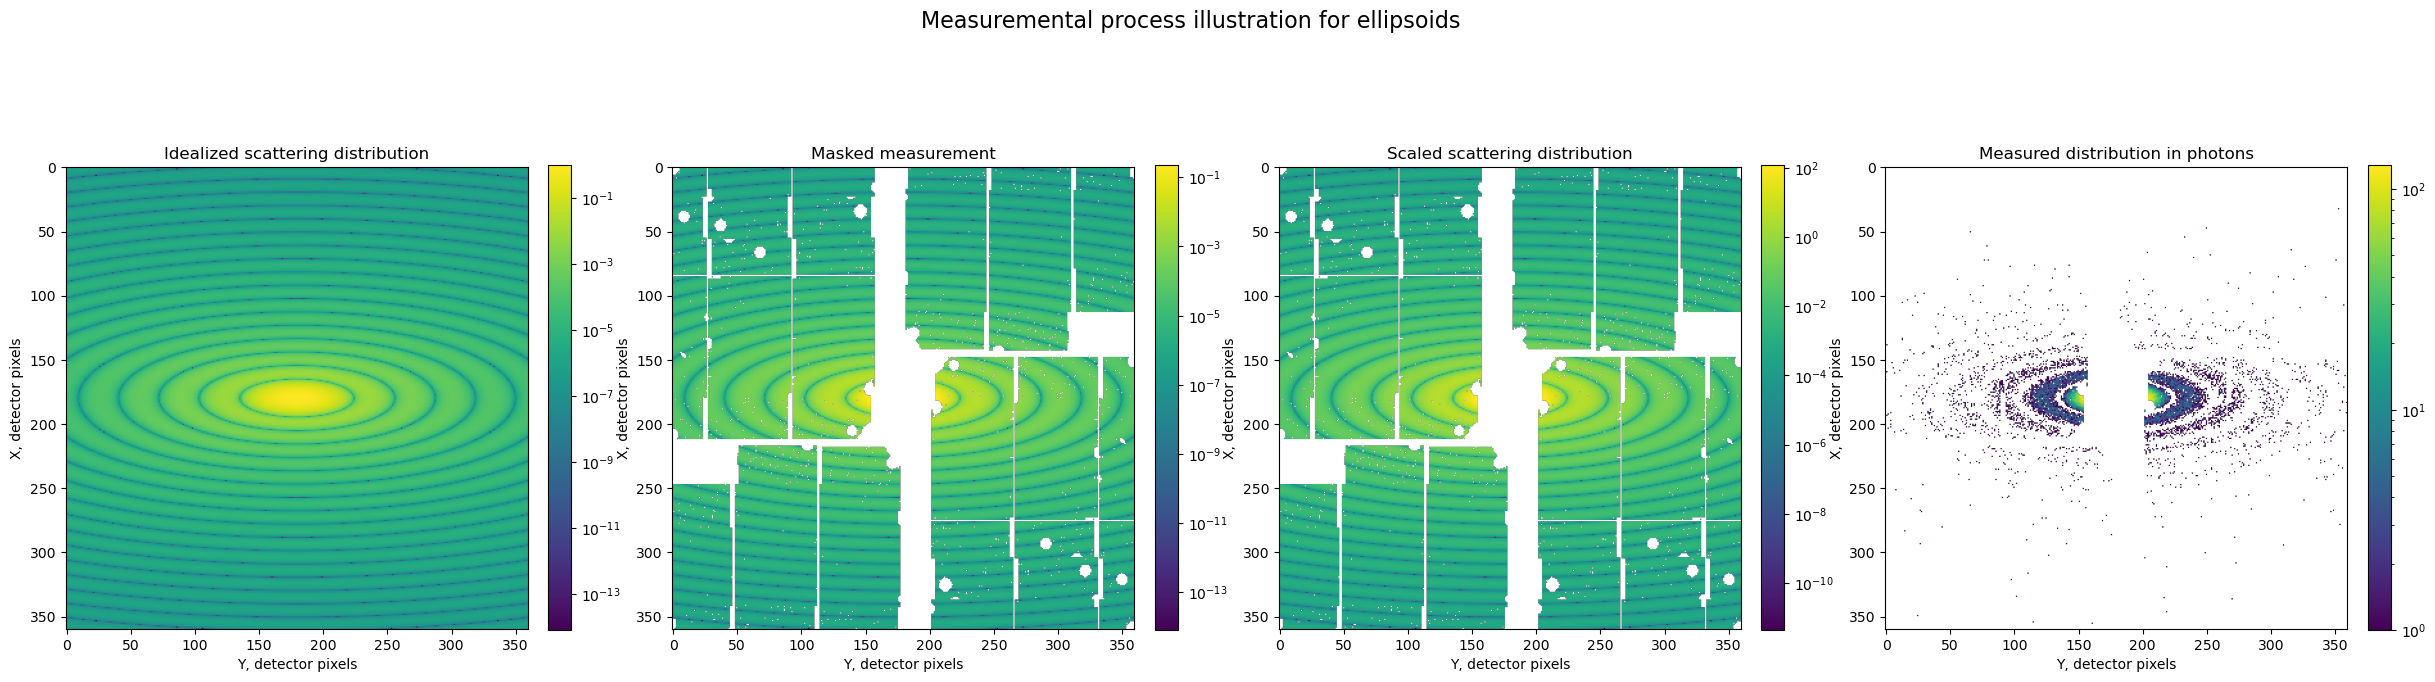

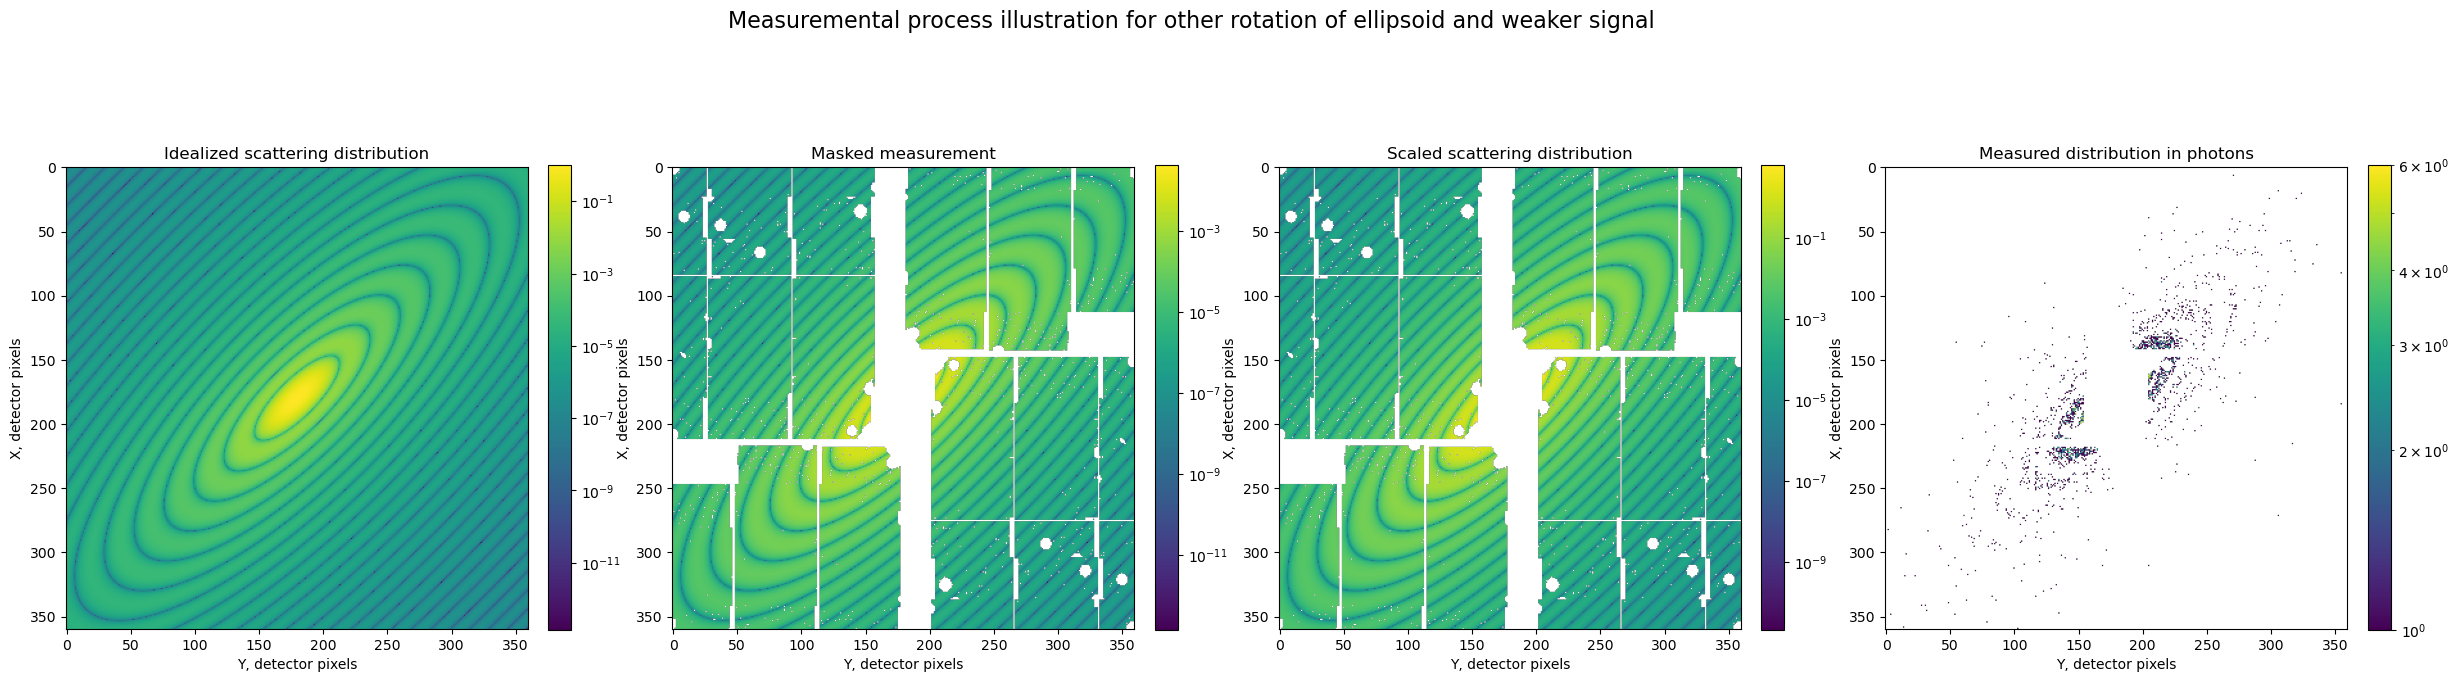

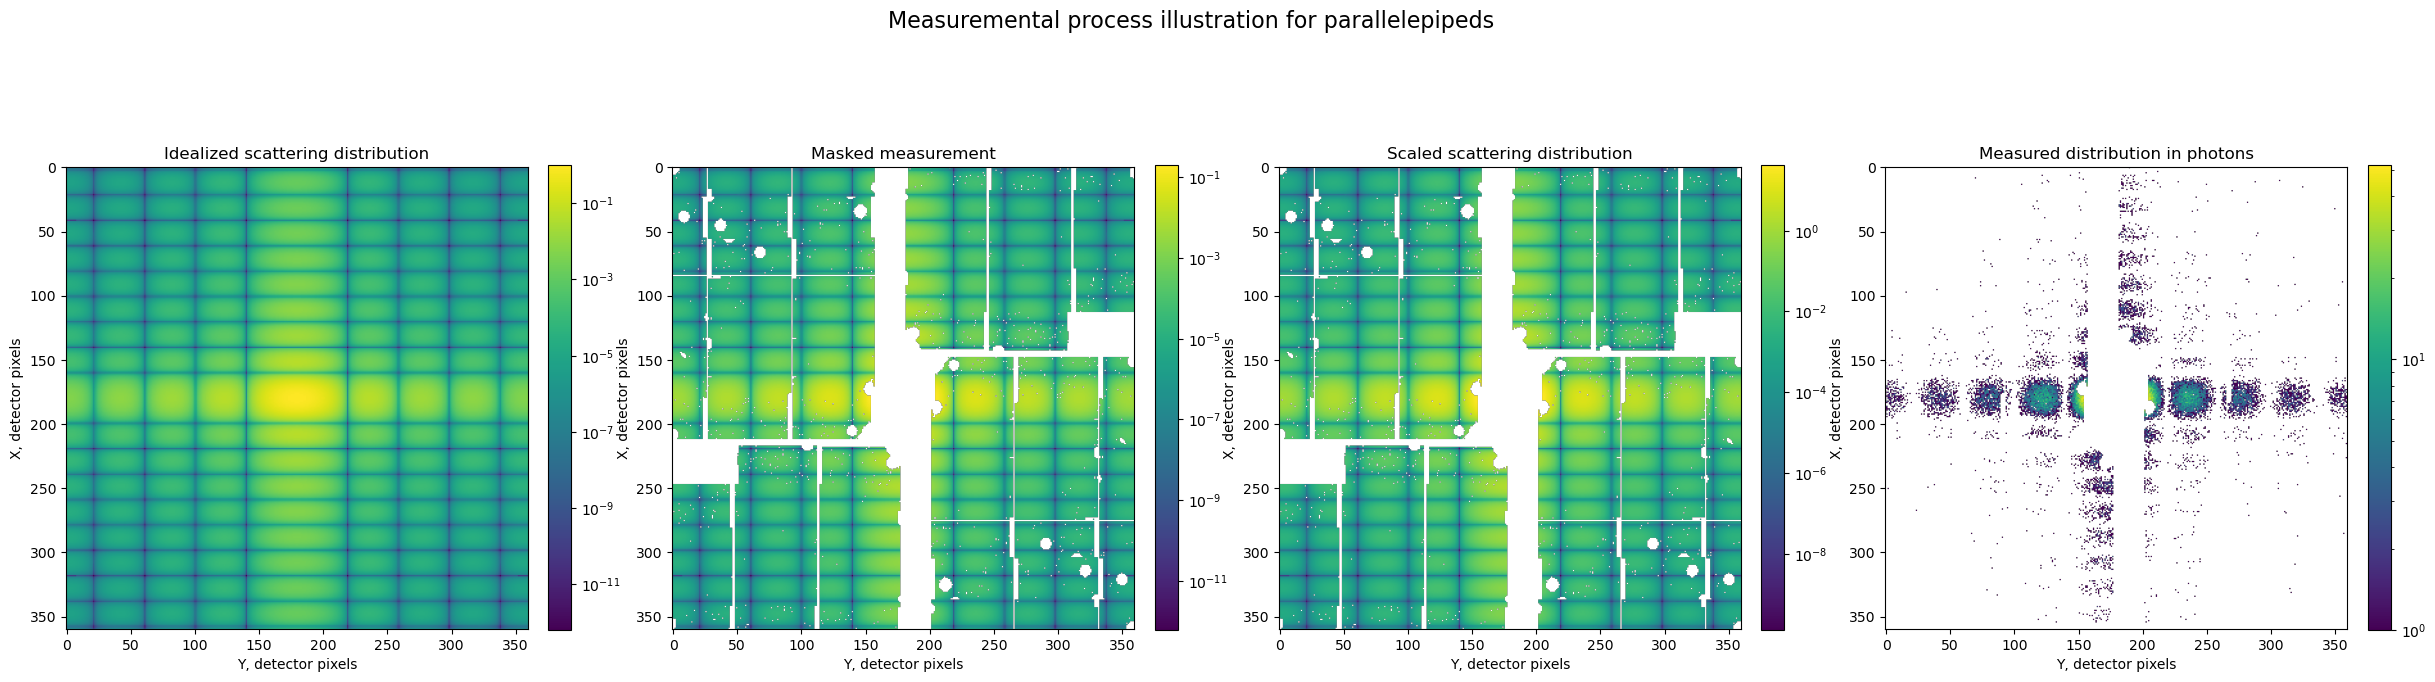

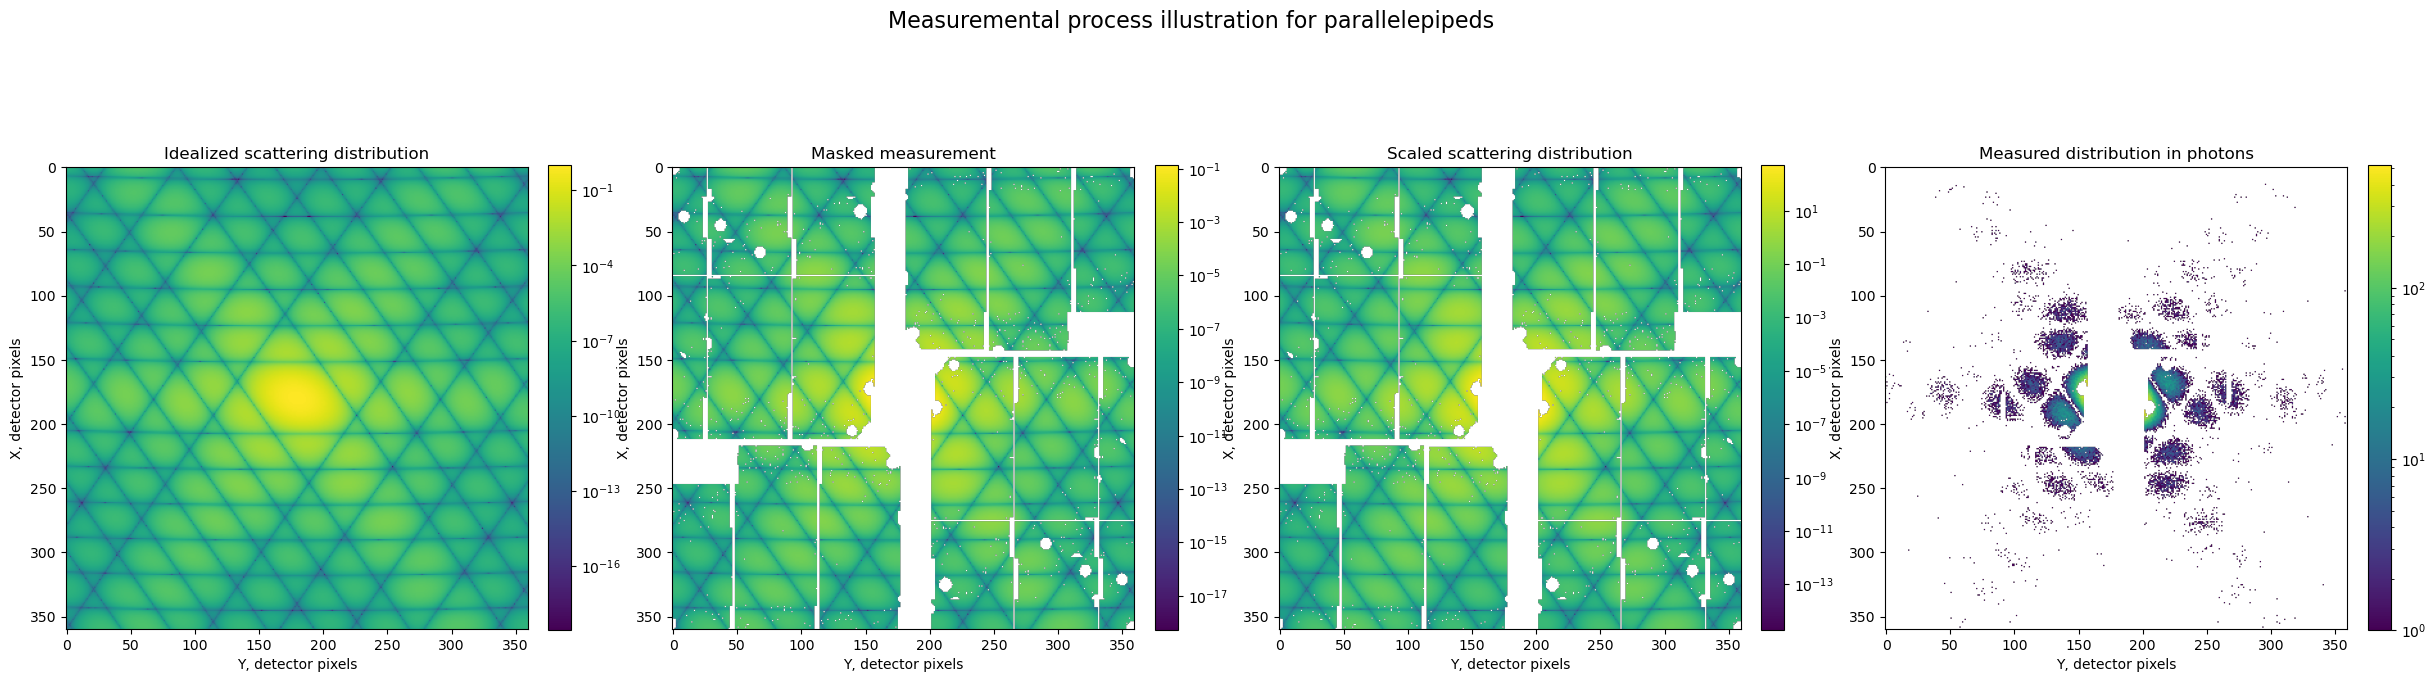

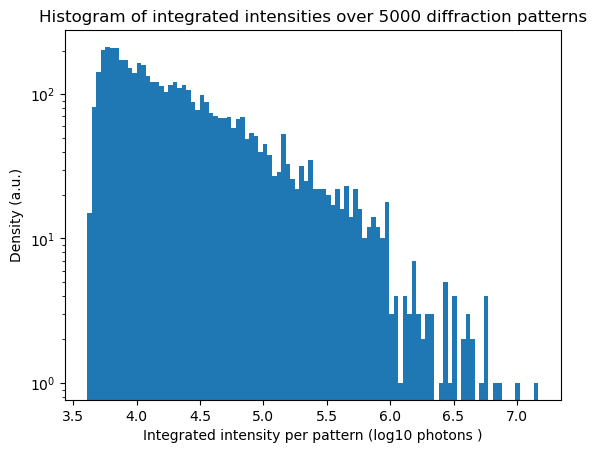

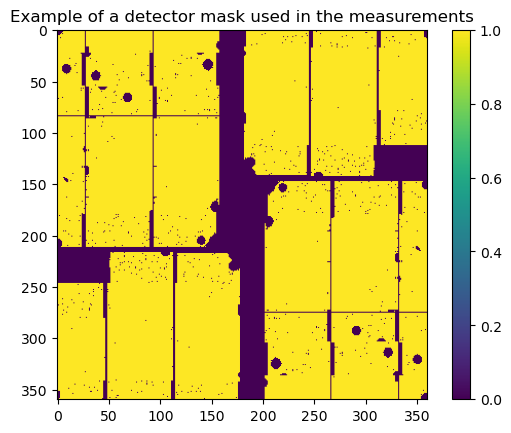

In [8]:
# Generate some diffraction patterns from ellipsoids and parallelepipeds
# and show how they're transformed through the measurement process




# Define the detector geometry and calculate the q_xyz grid for reciprocal space
xy,z = xyyz_from_detector_geometry(200e-6,1.2,360,360)
q_xyz = q_from_xyz(xy, z, 0.207e-9)




# Generate ellipsoid diffraction pattern
scattering_intensity = generate_ellipsoid_diffraction(q_xyz, 20e-9, 60e-9, 30e-9,0,0,0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 8))

im = ax1.imshow(scattering_intensity, norm="log", cmap="viridis")
ax1.set_xlabel("Y, detector pixels")
ax1.set_ylabel("X, detector pixels")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Idealized scattering distribution")


masked_intensity = masks[0] * scattering_intensity
im2 = ax2.imshow(
    masked_intensity,
    norm="log",
    cmap="viridis",
)
ax2.set_xlabel("Y, detector pixels")
ax2.set_ylabel("X, detector pixels")
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title("Masked measurement")



photon_number = 20e3
scaled_intensity = masked_intensity / masked_intensity.sum() * photon_number

im3 = ax3.imshow(scaled_intensity, norm="log", cmap="viridis")
ax3.set_xlabel("Y, detector pixels")
ax3.set_ylabel("X, detector pixels")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title("Scaled scattering distribution")

photonized_intensity = np.random.poisson(scaled_intensity)
im4 = ax4.imshow(photonized_intensity, norm="log", cmap="viridis")
ax4.set_xlabel("Y, detector pixels")
ax4.set_ylabel("X, detector pixels")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
ax4.set_title("Measured distribution in photons")

fig.suptitle("Measuremental process illustration for ellipsoids", fontsize=16)
plt.show()





# Generate ellipsoid diffraction pattern
scattering_intensity = generate_ellipsoid_diffraction(q_xyz, 20e-9, 60e-9, 30e-9,0,0,45)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 8))

im = ax1.imshow(scattering_intensity, norm="log", cmap="viridis")
ax1.set_xlabel("Y, detector pixels")
ax1.set_ylabel("X, detector pixels")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Idealized scattering distribution")


masked_intensity = masks[0] * scattering_intensity
im2 = ax2.imshow(
    masked_intensity,
    norm="log",
    cmap="viridis",
)
ax2.set_xlabel("Y, detector pixels")
ax2.set_ylabel("X, detector pixels")
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title("Masked measurement")



photon_number = 2e3
scaled_intensity = masked_intensity / masked_intensity.sum() * photon_number

im3 = ax3.imshow(scaled_intensity, norm="log", cmap="viridis")
ax3.set_xlabel("Y, detector pixels")
ax3.set_ylabel("X, detector pixels")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title("Scaled scattering distribution")

photonized_intensity = np.random.poisson(scaled_intensity)
im4 = ax4.imshow(photonized_intensity, norm="log", cmap="viridis")
ax4.set_xlabel("Y, detector pixels")
ax4.set_ylabel("X, detector pixels")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
ax4.set_title("Measured distribution in photons")

fig.suptitle("Measuremental process illustration for other rotation of ellipsoid and weaker signal", fontsize=16)
plt.show()





# Generate parallelepiped diffraction pattern
scattering_intensity = generate_parallelepiped_diffraction(q_xyz, 10e-9, 20e-9, 15e-9,0,0,0)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 8))

im = ax1.imshow(scattering_intensity, norm="log", cmap="viridis")
ax1.set_xlabel("Y, detector pixels")
ax1.set_ylabel("X, detector pixels")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Idealized scattering distribution")


masked_intensity = masks[0] * scattering_intensity
im2 = ax2.imshow(
    masked_intensity,
    norm="log",
    cmap="viridis",
)
ax2.set_xlabel("Y, detector pixels")
ax2.set_ylabel("X, detector pixels")
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title("Masked measurement")



photon_number = 20e3
scaled_intensity = masked_intensity / masked_intensity.sum() * photon_number

im3 = ax3.imshow(scaled_intensity, norm="log", cmap="viridis")
ax3.set_xlabel("Y, detector pixels")
ax3.set_ylabel("X, detector pixels")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title("Scaled scattering distribution")

photonized_intensity = np.random.poisson(scaled_intensity)
im4 = ax4.imshow(photonized_intensity, norm="log", cmap="viridis")
ax4.set_xlabel("Y, detector pixels")
ax4.set_ylabel("X, detector pixels")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
ax4.set_title("Measured distribution in photons")



fig.suptitle("Measuremental process illustration for parallelepipeds", fontsize=16)
plt.show()


# Generate parallelepiped diffraction pattern
scattering_intensity = generate_parallelepiped_diffraction(q_xyz, 10e-9, 20e-9, 15e-9,45,45,0)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 8))

im = ax1.imshow(scattering_intensity, norm="log", cmap="viridis")
ax1.set_xlabel("Y, detector pixels")
ax1.set_ylabel("X, detector pixels")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Idealized scattering distribution")


masked_intensity = masks[0] * scattering_intensity
im2 = ax2.imshow(
    masked_intensity,
    norm="log",
    cmap="viridis",
)
ax2.set_xlabel("Y, detector pixels")
ax2.set_ylabel("X, detector pixels")
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title("Masked measurement")



photon_number = 60e3
scaled_intensity = masked_intensity / masked_intensity.sum() * photon_number

im3 = ax3.imshow(scaled_intensity, norm="log", cmap="viridis")
ax3.set_xlabel("Y, detector pixels")
ax3.set_ylabel("X, detector pixels")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title("Scaled scattering distribution")

photonized_intensity = np.random.poisson(scaled_intensity)
im4 = ax4.imshow(photonized_intensity, norm="log", cmap="viridis")
ax4.set_xlabel("Y, detector pixels")
ax4.set_ylabel("X, detector pixels")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
ax4.set_title("Measured distribution in photons")



fig.suptitle("Measuremental process illustration for parallelepipeds", fontsize=16)
plt.show()

plt.figure()
plt.hist(jnp.log10(intensities), bins=100, density=False, log=True)
plt.xlabel("Integrated intensity per pattern (log10 photons )")
plt.ylabel("Density (a.u.)")
plt.title("Histogram of integrated intensities over 5000 diffraction patterns")
plt.show()


plt.figure()
plt.imshow(masks[0, :, :])
plt.title("Example of a detector mask used in the measurements")
plt.colorbar();

# How to load from simmulated data

I've stored simmulated templates into the file at 
```
'/gpfs/exfel/exp/SPB/202503/p008047/scratch/Konstantin/templates/simulated_data.h5'
```

the file structure is illustrated in the next cell.

It's a lot of simmulated diffraction patterns per a particle shape (ellipsoid,rectangle,cube,sphere) with relewant sizes and rotations used for generation stored in the same subfolders.
I will add 'ugly' diffraction patterns for non-structured shapes later.

Additionally, you'd need to use the masks and photon scaling factors to simmulate a realistic measurement as shown below.


Please consider the sampling strategy for the training pipeline. It's a lot of patterns with rougly 560K of parallelipipeds (including cubes and rectangles) and only 10 K of ellipsoids (including spheres) because the parameter space for an parallelipipeds diffraction patterns is much bigger than the one for ellipsoids. However during the training process we'll need to consider this  imbalance and sample accourdingly since we don't want to bias our model to ellipsoids, cuboids or ugly particles.



In [15]:
with h5py.File(simmulated_file_path,'r') as f:
    print (tuple(f['diffraction_patterns'].keys()))

('ellipsoids', 'paralelipiped', 'rectangles', 'spheres', 'squares')


In [32]:
simmulated_file_path = (
    "/gpfs/exfel/exp/SPB/202503/p008047/scratch/Konstantin/templates/simulated_data.h5"
)


def print_h5_tree(name: str, obj, indent: int = 0) -> None:
    pad = "  " * indent
    if isinstance(obj, h5py.Group):
        print(f"{pad}📁 {name}/")
        for key, val in obj.items():
            print_h5_tree(key, val, indent + 1)
    elif isinstance(obj, h5py.Dataset):
        shape = obj.shape
        dtype = obj.dtype
        print(f"{pad}📄 {name}  shape={shape}, dtype={dtype}")


def get_realistic_measurement(
    filename: str,
    particle_type: int,
    particle_id: str,
    mask_id: int,
    scale_factor_id: int,
) -> tuple[np.ndarray, np.ndarray, np.int]:
    with h5py.File(filename, "r") as f:

        data_name = tuple(f["diffraction_patterns"].keys())[particle_type]
        data_group = f["diffraction_patterns"][data_name]
        parameters_group = f["measured_parameters"]
        data = data_group["patterns"][particle_id,...]
        mask = parameters_group["masks"][mask_id,...]
        scale_factor = parameters_group["scattered_photons"][scale_factor_id]
    return data, mask, scale_factor


with h5py.File(simmulated_file_path,'r') as f:
    print_h5_tree("simulated_data", f)

📁 simulated_data/
  📁 diffraction_patterns/
    📁 ellipsoids/
      📄 A_B_phi  shape=(3, 6840), dtype=float32
      📄 patterns  shape=(6840, 360, 360), dtype=float32
    📁 paralelipiped/
      📄 A_B_C_phi_theta_omega_  shape=(6, 558600), dtype=float32
      📄 patterns  shape=(558600, 360, 360), dtype=float32
    📁 rectangles/
      📄 A_B_phi  shape=(3, 6840), dtype=float32
      📄 patterns  shape=(6840, 360, 360), dtype=float32
    📁 spheres/
      📄 A  shape=(150,), dtype=float32
      📄 patterns  shape=(150, 360, 360), dtype=float32
    📁 squares/
      📄 patterns  shape=(2250, 360, 360), dtype=float32
      📄 side_nm angle_deg  shape=(2, 2250), dtype=float32
  📁 experiment_geometry/
    📄 q_xyz  shape=(3, 360, 360), dtype=float32
    📄 xy  shape=(2, 360), dtype=float32
    📄 z  shape=(), dtype=float32
  📁 measured_parameters/
    📄 masks  shape=(7966, 360, 360), dtype=bool
    📄 scattered_photons  shape=(7966,), dtype=int64


In [52]:
scattering,mask,scaling =get_realistic_measurement(simmulated_file_path,1,150000,1,1)

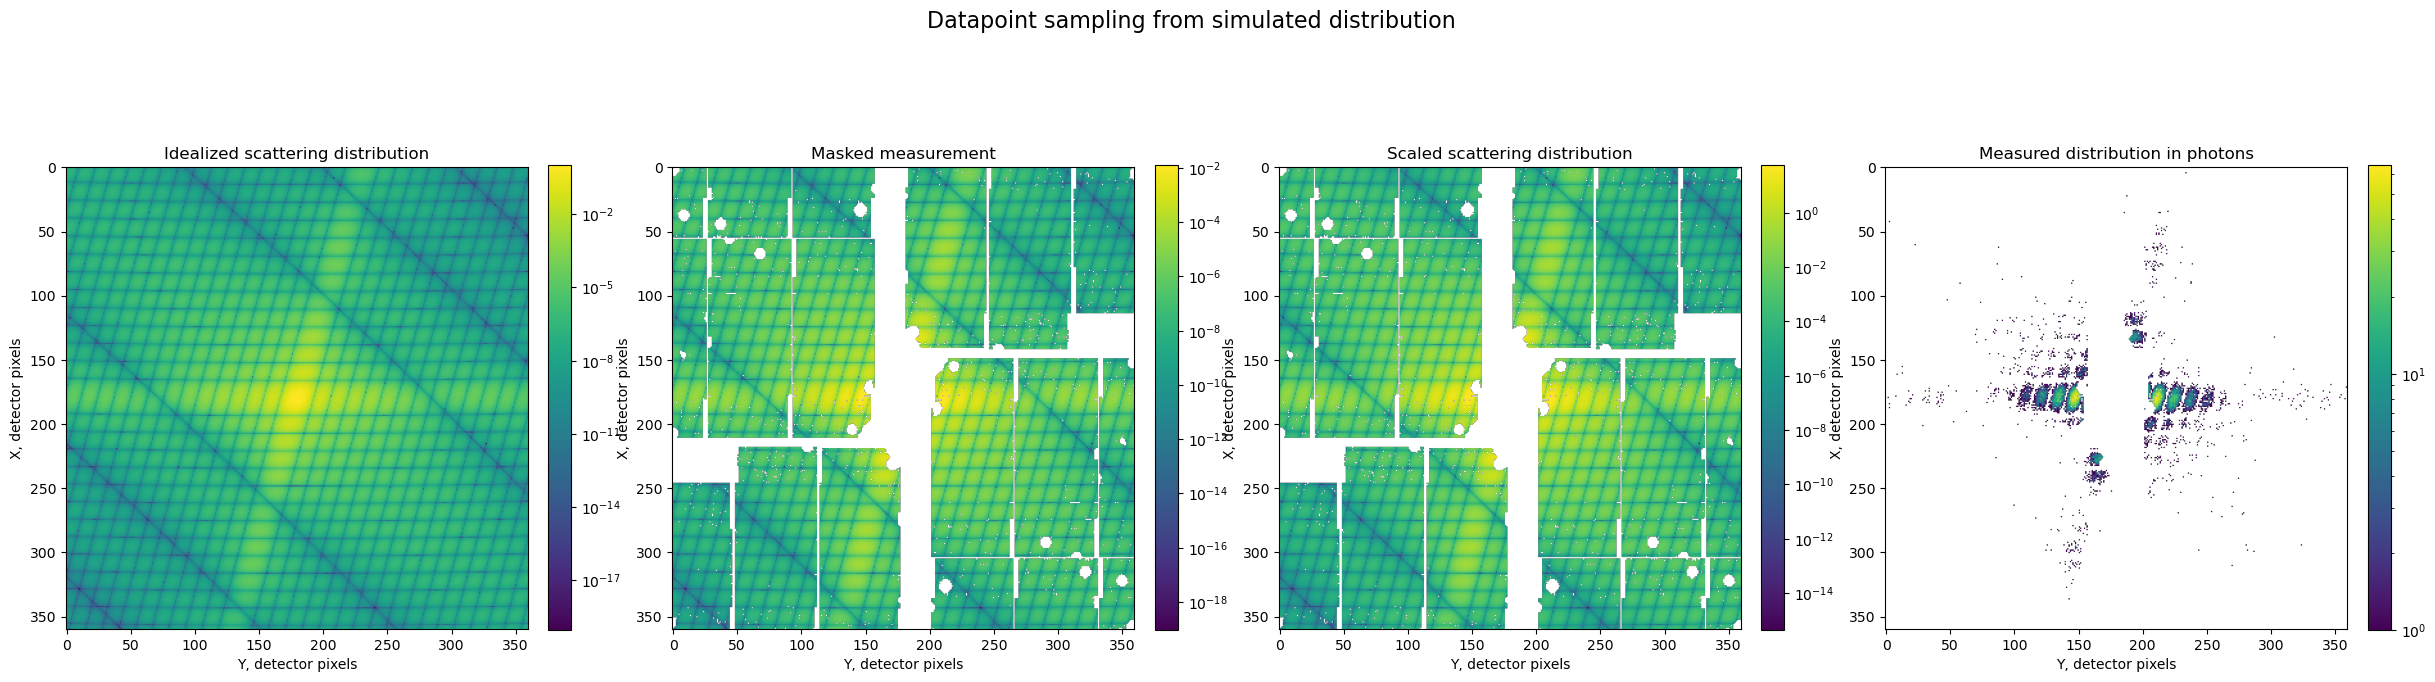

In [56]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 8))

im = ax1.imshow(scattering, norm="log", cmap="viridis")
ax1.set_xlabel("Y, detector pixels")
ax1.set_ylabel("X, detector pixels")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Idealized scattering distribution")


masked_intensity = mask * scattering
im2 = ax2.imshow(
    masked_intensity,
    norm="log",
    cmap="viridis",
)
ax2.set_xlabel("Y, detector pixels")
ax2.set_ylabel("X, detector pixels")
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title("Masked measurement")



photon_number = scaling
scaled_intensity = masked_intensity / masked_intensity.sum() * photon_number

im3 = ax3.imshow(scaled_intensity, norm="log", cmap="viridis")
ax3.set_xlabel("Y, detector pixels")
ax3.set_ylabel("X, detector pixels")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title("Scaled scattering distribution")

photonized_intensity = np.random.poisson(scaled_intensity)
im4 = ax4.imshow(photonized_intensity, norm="log", cmap="viridis")
ax4.set_xlabel("Y, detector pixels")
ax4.set_ylabel("X, detector pixels")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
ax4.set_title("Measured distribution in photons")
fig.suptitle("Datapoint sampling from simulated distribution", fontsize=16);